# YOLOv2 物體偵測範例
在[3.0: YOLO物體偵測演算法概念與介紹](https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/3.0-yolo-algorithm-introduction.ipynb)的文章裡介紹了YOLO演算法一些重要概念與其它物體偵測演算法的不同之處。

這一篇文章則是要手把手地介紹如何使用Darknet預先訓練YOLOv2的模型以及使用[YAD2K](https://github.com/allanzelener/YAD2K)(使用Tensorflow與Keras的Yolov2實作函式庫)來偵測圖像裡的物體對象。

![yolo](https://cdn-images-1.medium.com/max/1000/1*4YcPtqv9myJ1vypgb5wKnA.png)

## YAD2K專案說明

[YAD2K](https://github.com/allanzelener/YAD2K) (Yet Another Darknet 2 Keras) 是YOLO_v2演算法實現專案(90%的程式碼使用了Keras、10%的程式碼使用了Tensorflow)。

原始論文: [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) by Joseph Redmond and Ali Farhadi.

### 需求

- [Keras](https://github.com/fchollet/keras)
- [Tensorflow](https://www.tensorflow.org/)
- [Numpy](http://www.numpy.org/)
- [h5py](http://www.h5py.org/) (For Keras model serialization.)
- [Pillow](https://pillow.readthedocs.io/) (For rendering test results.)
- [Python 3](https://www.python.org/)
- [pydot-ng](https://github.com/pydot/pydot-ng) (Optional for plotting model.)

### 安裝

```bash
git clone https://github.com/allanzelener/yad2k.git
cd yad2k

# [Option 1] To replicate the conda environment:
conda env create -f environment.yml
source activate yad2k
# [Option 2] Install everything globaly.
pip install numpy h5py pillow
pip install tensorflow-gpu  # CPU-only: conda install -c conda-forge tensorflow
pip install keras # Possibly older release: conda install keras
```


### 模型轉換

1. 從[YOLO官方網站](http://pjreddie.com/darknet/yolo/)下載Darknet模型的設置檔與權重檔到專案根目錄。例如:使用MS COCO資料集訓練的預訓練模型
    * 下載[YOLOv2 608x608 設置檔(yolo.cfg)](https://github.com/pjreddie/darknet/blob/master/cfg/yolo.cfg)
    * 下載[YOLOv2 608x608 權重檔(yolo.weights)](https://pjreddie.com/media/files/yolo.weights)
2. 將原本使用Darknet預訓練的YOLO_v2模型透過`yad2k.python`命令稿來轉換為Keras模型
    - 例如: `python yad2k.py yolo.cfg yolo.weights model_data/yolov2_coco_608x608.h5`
  
最後你的目錄結構看起來像這樣: (這裡只列出來在這個範例會用到的相關檔案與目錄)
```
xxxx.ipynb
yad2k.py
yolo.cfg
yolo.weights
├── font/
│   └── FiraMono-Medium.otf
├── images/
│   └── dog.jpg
├── yad2k/
│   ├── __init__.py
│   ├── models/
│   ├── utils/
│   └── __pycache__/
└── model_data/
    ├── coco_classes.txt
    ├── pascal_classes.txt
    ├── yolov2_coco_608x608.h5
    └── yolov2_coco_608x608_anchors.txt
    
```

### 載入相關函式庫

In [1]:
import warnings
warnings.filterwarnings('ignore') # 暫時隱藏一些Warning訊息

import os
import random
import numpy as np
import platform
import tensorflow
import keras
from keras import backend as K
from keras.models import load_model
from keras.utils import plot_model

from PIL import Image, ImageDraw, ImageFont
import colorsys
import imghdr
from yad2k.models.keras_yolo import yolo_eval, yolo_head
import cv2
from tqdm import tqdm
import time
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as display

%matplotlib inline

print("Platform: {}".format(platform.platform()))
print("Tensorflow version: {}".format(tensorflow.__version__))
print("Keras version: {}".format(keras.__version__))

Using TensorFlow backend.


Platform: Windows-7-6.1.7601-SP1
Tensorflow version: 1.4.0
Keras version: 2.1.1


### 設定相關基相設定與參數

In [2]:
# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 模型相關資料的目錄
MODEL_PATH = os.path.join(ROOT_DIR, "model_data")

# 圖像類別定義文件路徑，預設為"coco_classes.txt"
CLASSES_FILE_PATH = os.path.join(MODEL_PATH, "coco_classes.txt")

# 設定模型權重檔案
MODEL_FILENAME = "yolov2_coco_608x608.h5"

# 設定模型權重檔案路徑
MODEL_FILE_PATH = os.path.join(MODEL_PATH, MODEL_FILENAME)

# 設定錨點文件檔案
ANCHORS_FILENAME = "yolov2_coco_608x608_anchors.txt"

# 錨點文件的路徑，預設為"yolo_anchors.txt" (x1,y1,x2,y2,x3,y3,x4,y4,x5,y5)
ANCHORS_FILE_PATH = os.path.join(MODEL_PATH, ANCHORS_FILENAME)

# 模型輸入的圖像大小與顏色頻道數
IMAGE_HEIGHT = 608
IMAGE_WEIGHT = 608
IMAGE_CHANNELS = 3

# 設定邊界框過濾的閥值(confidence score)
SCORE_THRESHOLD = 0.3

# IOU(Intersection over Union)的閥值
IOU_THRESHOLD = 0.5

# 驗證用的圖像目錄，預設為"images/"
TEST_PATH = os.path.join(ROOT_DIR, "images")

# 處理結果的圖像目錄，預設為"images/out"
OUTPUT_PATH = os.path.join(ROOT_DIR, "images_out")

In [3]:
# 檢查"OUTPUT_PATH"的目錄是否存在
if not os.path.exists(OUTPUT_PATH):
    print('Creating output path {}'.format(OUTPUT_PATH))
    os.mkdir(OUTPUT_PATH)

In [4]:
# 取得Tensorflow的session物件
sess = K.get_session()

In [5]:
# 取得物件的類別名稱(要看模型是用那一種資料集來進行訓練)
with open(CLASSES_FILE_PATH) as f:
    class_names = f.readlines() # 一行是一個圖像類別

# 把這些圖像類別放到一個列表中
class_names = [c.strip() for c in class_names]

In [6]:
# 取得圖像的預設錨點 (x1,y1,x2,y2,x3,y3,x4,y4,x5,y5)
with open(ANCHORS_FILE_PATH) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2) # 錨點是 (x, y) 一組

### 載入網絡結構模型

In [7]:
# 載入由Darknet轉換的YOLOv2模型
yolo_model = load_model(MODEL_FILE_PATH)

In [8]:
# 打印模型結構
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
leaky_re_lu_12 (LeakyReLU)      (None, 38, 38, 256)  0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 38, 38, 512)  1179648     leaky_re_lu_12[0][0]             
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 38, 38, 512)  2048        conv2d_13[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_13 (LeakyReLU)      (None, 38, 38, 512)  0           batch_normalization_13[0][0]     
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 19, 19, 512)  0           leaky_re_lu_13[0][0]             
__________

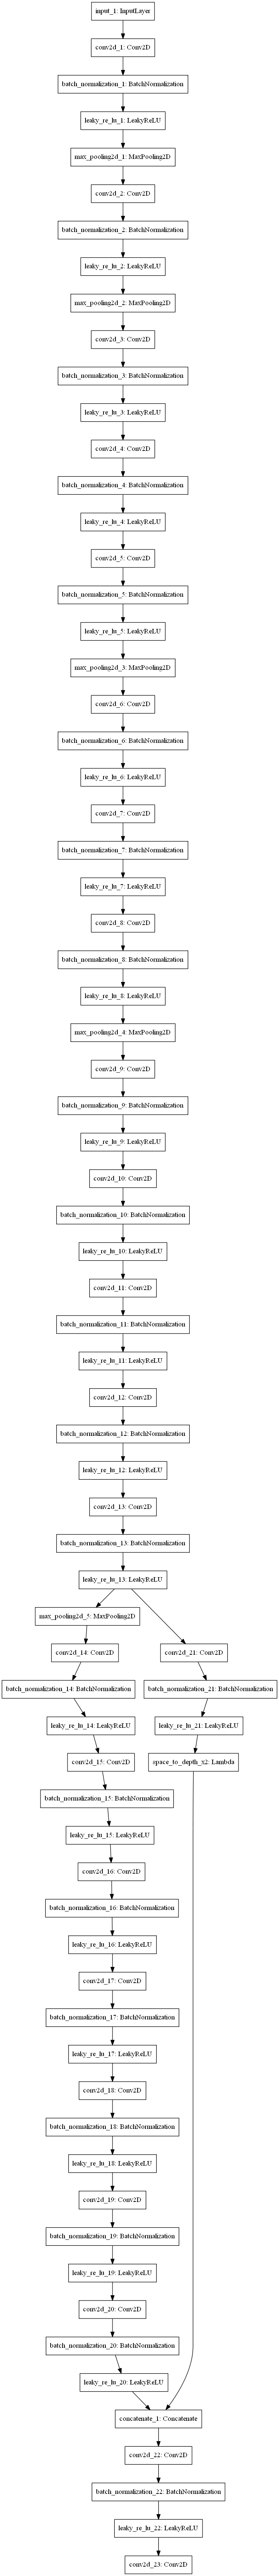

In [9]:
# 產生網絡拓撲圖
plot_model(yolo_model, to_file='yolov2_model.png')

# 秀出網絡拓撲圖
display.Image('yolov2_model.png')

In [10]:
num_classes = len(class_names) # "coco" -> 80, "pacal" -> 20
num_anchors = len(anchors) # 錨點個數

# 取出YOLOv2模型的最後一層 -> "conv2d_23"的輸出為 (19, 19, 425)
model_output_channels = yolo_model.layers[-1].output_shape[-1] 

# 最後的features map的維度是19x19x425 (為什麼是425)
# 主要是因為YOLOv2把整個圖像分成19x19個小區塊(cell)
# 而每個小區塊(cell)要predict"num_anchors(5)"個邊界框(bounding boxes)
# 因此(19, 19, 425)中的前2個維度就是定義每一個小區塊(cell), 而"425"則代表著:
#     - x, y, width, height (定義邊界框的座標) -> 4個浮點數
#     - 邊界框裡包含物體的信心分數(confidence score) -> 1個浮點數
#     - 每一種類別的機率(num_classes) -> 80個浮點數 (MS Coco的資料集有80種圖像類別)


# 驗證 model, anchors, 與 classes 是相符合的
if model_output_channels != (num_anchors * (num_classes + 5)):
    print('Mismatch between model and given anchor and class sizes.')
    
print('model[{}] , anchors[{}], and classes[{}] loaded.'.format(MODEL_FILENAME, num_anchors, num_classes))

model[yolov2_coco_608x608.h5] , anchors[5], and classes[80] loaded.


In [11]:
# 檢查模型的Input圖像大小
model_image_size = yolo_model.layers[0].input_shape[1:3] # (h, w, channel)

is_fixed_size = model_image_size != (None, None) # 如果 h, w都是"None"代表任何圖像的size都可以
print("Flag: is_fixed_size [{}]".format(is_fixed_size))

print("Model input image size: ", model_image_size) # 打印出來看一下

Flag: is_fixed_size [True]
Model input image size:  (608, 608)


In [12]:
# 為不同的bounding boxes產生不同的顏色
hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]

colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

random.seed(10101) # 設定random的seed讓整個運行中的顏色有一致性。
random.shuffle(colors) # 打散顏色
random.seed(None) # 回複到預設值

In [13]:
# 將最後的圖層特徵轉換為邊界框的相對參數。
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

input_image_shape = K.placeholder(shape=(2, ))

# 使用YOLO模型評估給定的輸入批次和相關的閥值, 返回過濾後的邊界框。
boxes, scores, classes = yolo_eval(yolo_outputs,
                                  input_image_shape,
                                  score_threshold=SCORE_THRESHOLD,
                                  iou_threshold=IOU_THRESHOLD)

## 圖像的物體偵測

先看一下原始的要用來測試的圖像

In [14]:
# 指定要用來進行物體偵測的圖像
TEST_IMG = "dog.jpg" # <----- 你可以替換其它不同的圖像

# 驗證用的圖像目錄，預設為"images/"
TEST_IMG_PATH = os.path.join(TEST_PATH, TEST_IMG)

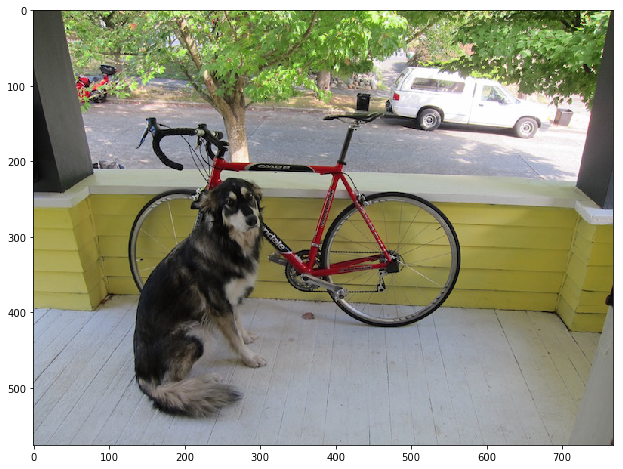

In [15]:
# 將原始的圖像秀出來
plt.figure(figsize=(15,8)) # 設定展示圖像的大小
img=plt.imread(TEST_IMG_PATH) # 讀入圖像
plt.imshow(img) # 展示

## 使用YOLOv2來偵測物體

YOLO的模型主要的任務有兩個:
1. 偵測邊界框(Bounding boxes)
2. 對邊界框裡的物體進行辨識(Object recognition)


由於我們使用了Darknet使用MS COCO圖像集所預訓練的YOLOv2 608x608模型。這個預訓練的模型預期它的圖像輸人有以下的前處理:
1. 圖像資料的張量形狀(tensor shape)為(608, 608, 3)也就是圖像RGB三色頻且大小為608x608
2. 圖像的張量需要進行歸一化的處理(除以255)以及資料型別為浮點數32

### 資料前處理

In [16]:
# 載入圖像
image = Image.open(TEST_IMG_PATH)

print("Before image resize: ", np.array(image, dtype='float32').shape)

# 修改輸入圖像大小來符合模型的要求
resized_iamge = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
image_data = np.array(resized_iamge, dtype='float32') # (img_height, img_width, img_channels)

print("After image resize: ", image_data.shape)
    
# 進行圖像歸一處理
image_data /= 255.

# 增加"批次"的維度
print("Before expand dims:",image_data.shape) # (img_height, img_width, img_channels)

image_data = np.expand_dims(image_data, 0) # 增加 batch dimension

print("After expand dims:",image_data.shape) # (sample_size, img_height, img_width, img_channels)

Before image resize:  (576, 768, 3)
After image resize:  (608, 608, 3)
Before expand dims: (608, 608, 3)
After expand dims: (1, 608, 608, 3)


### 資料的推論預測

由於YAD2K的YOLO的實作混合了Keras與Tensorflow, 因此在預測的階段需要使用Tensorflow的Session物件。

由於一個圖像中可能有多個邊界框, 因此在YOLO的模型在進行圖像的輸入之後會有以下的輸出:
1. 邊界框列表(boxes)-列表中的每個資料結構包括了4個浮點數, 分別代表左上角的(x1,y1)及右下角的(x2,y2)
2. 邊界框信心分數列表(confidence scores)-列表中的每個資料結構包括了1個浮點數, 代表每個邊界框有物體在框內的信心分數
3. 邊界框物體類別機率列表(object category probabilities)-列表中的每個資料結構包括了1個整數, 它代表機率值最大的那一個物體類別的索引

In [17]:
# 取得YOLOv2模型偵測後的結果
out_boxes, out_scores, out_classes = sess.run([boxes, scores, classes],
                                             feed_dict={
                                                 yolo_model.input: image_data,
                                                 input_image_shape: [image.size[1], image.size[0]],
                                                 K.learning_phase(): 0
                                             })

print("out_boxes.shape:", out_boxes.shape, out_boxes.dtype)
print("out_scores.shape:", out_scores.shape, out_scores.dtype)
print("out_classes.shape:", out_classes.shape, out_classes.dtype)

out_boxes.shape: (3, 4) float32
out_scores.shape: (3,) float32
out_classes.shape: (3,) int64


In [18]:
# 打印找到個bounding boxes    
print('Found {} boxes for {}'.format(len(out_boxes),TEST_IMG))

# 打印每個找到的物體類別、信心分數與邊界框的左上角與右下角座標
for i, c in reversed(list(enumerate(out_classes))):
    predicted_class = class_names[c]
    box = out_boxes[i]
    score = out_scores[i]
    
    top, left, bottom, right = box
    top = max(0, np.floor(top + 0.5).astype('int32'))                   # 避免左上角座標超出原始圖像的左上角(0,0)
    left = max(0, np.floor(left + 0.5).astype('int32'))                 # 避免左上角座標超出原始圖像的左上角(0,0)
    bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32')) # 避免右下角座標超出原始圖像的右下角(608,608)
    right = min(image.size[0], np.floor(right + 0.5).astype('int32'))   # 避免右下角座標超出原始圖像的右下角(608,608)
    
    label = '{} {:.2f} [({}, {}),({}, {})]'.format(predicted_class, score, top, left, bottom, right)
    print(label)

Found 3 boxes for dog.jpg
dog 0.78 [(214, 137),(540, 323)]
truck 0.80 [(82, 462),(168, 694)]
bicycle 0.84 [(112, 81),(469, 554)]


### 圖像偵測結果

將找到的物體類別、信心分數與邊界框秀到圖像上

dog 0.78 (137, 214) (323, 540)
truck 0.80 (462, 82) (694, 168)
bicycle 0.84 (81, 112) (554, 469)


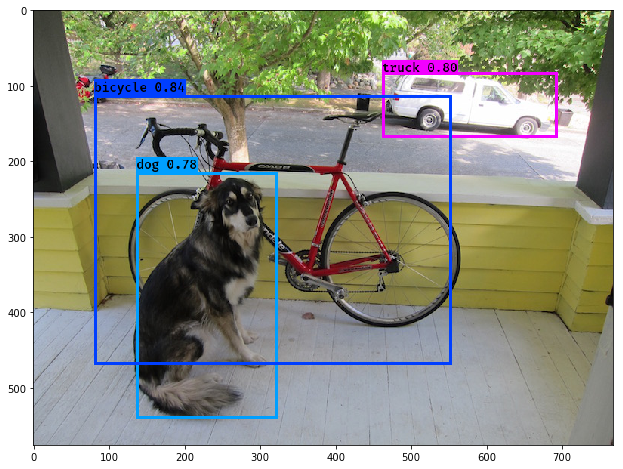

In [19]:
# 設定字型
font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                         size=np.floor(3e-2 * image.size[1]+0.5).astype('int32'))

# 設定邊界框的厚度
thickness = (image.size[0]+image.size[1]) // 300

# 迭代每個找到的物體類別
for i, c in reversed(list(enumerate(out_classes))):
    predicted_class = class_names[c]
    box = out_boxes[i]
    score = out_scores[i]

    label = '{} {:.2f}'.format(predicted_class, score)

    draw = ImageDraw.Draw(image) # 使用Draw物件來在圖像上畫圖
    
    label_size = draw.textsize(label, font) # 將"物體類別"與"信心分數"以文字的方式展現
    
    # "邊界框"的座標
    top, left, bottom, right = box
    top = max(0, np.floor(top + 0.5).astype('int32'))
    left = max(0, np.floor(left + 0.5).astype('int32'))
    bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
    right = min(image.size[0], np.floor(right + 0.5).astype('int32'))

    # 打印圖像類別, 邊界框的左上角及右下角的座標
    print(label, (left, top), (right, bottom))

    if top - label_size[1] >= 0:
        text_origin = np.array([left, top - label_size[1]])
    else:
        text_origin = np.array([left, top + 1])

    
    for i in range(thickness):
        # 畫"邊界框"
        draw.rectangle(
            [left + i, top + i, right - i, bottom - i],
            outline=colors[c])
    
    # 畫一個四方型來做為文字標籤的背景
    draw.rectangle(
        [tuple(text_origin), tuple(text_origin + label_size)],
        fill=colors[c])
    
    # 把文字標籤的資訊放到圖像上
    draw.text(text_origin, label, fill=(0, 0, 0), font=font)
    
    del draw # 移除"draw"物件

# 將最後的圖像秀出來
plt.figure(figsize=(15,8)) # 設定展示圖像的大小
plt.imshow(image) # 展示

# 儲存處理過的圖像
# image.save(os.path.join(OUTPUT_PATH, image_file), quality=90)

In [20]:
# 關閉Tensorflow的Session
sess.close()

## 總結 (Conclusion)

在這篇文章中有一些個人學習到的一些有趣的重點:

* 因為開源所以大家都可以站在別人的肩膀上快速累積快速學習
* 很多看起來複雜的演算法, 當了解它的核心設計思想之後, 就會覺得簡單很多
* 很多不同深度學習框架所訓練出來的模型只要清楚它的架構後也可以快速的轉換到其它的框架上去使用
* 做為一個工程師也可以用整合性的角度來思考每種技術的應用與整合

參考:
* [YOLO官網](https://pjreddie.com/darknet/yolo/)
* [llSourcell/YOLO_Object_Detection](https://github.com/llSourcell/YOLO_Object_Detection)
* [allanzelener/YAD2K](https://github.com/allanzelener/YAD2K)